# Tarea 0

Primero, se debe crear un entorno virtual para evitar incompatibilidades con el resto del sistema. La celda de abajo se debe copiar y pegar en la terminal antes de correr el notebook.

In [1]:
%%sh
if [ ! -d ".venv" ]; then
    python3 -m venv .venv
    echo "Virtual environment created."
else
    echo "Virtual environment already exists."
fi

Virtual environment already exists.


Luego, se debe crear un entorno virtual e instalar las dependencias de Python necesarias.

In [2]:
import os
import platform

GREEN = '\033[92m'
BLUE = '\033[94m'
YELLOW = '\033[93m'
RED = '\033[91m'
RESET = '\033[0m'

system = platform.system().lower()

if system in ['linux', 'darwin']:  #*Linux or macOS
    activate_script = ".venv/bin/activate"
    print(f"To activate: {GREEN}source {activate_script}{RESET}")
elif system == 'windows':
    activate_script = ".venv\\Scripts\\activate.bat"
    print(f"To activate: {GREEN}{activate_script}{RESET}")
else:
    print(f"{RED}Unknown OS. Please activate manually.{RESET}")

if os.path.exists(".venv"):
    print(f"{BLUE}Virtual environment found.{RESET}")
else:
    print(f"{YELLOW}Virtual environment not found. Please create it first.{RESET}")

To activate: source .venv/bin/activate
Virtual environment found.


In [3]:
%%bash
# Reemplaza esta línea por el código en verde que te apareció en la salida de la celda inmediatamente anterior a esta

In [4]:
!pip install numpy networkx matplotlib scipy

## Parámetros iniciales

In [5]:
p_values: list[float] = [n/3 for n in range (1, 2)]
n_values: list[int] = [n for n in range (3, 4)]

## Funciones extra

Su objetivo es reutilizar código y abstraer diversos procesos para enfocarse en el análisis de complejidad de los dos algoritmos

In [6]:
import numpy as np

def build_p_matrices(chain: int = 1,
                     p_values: list[float] = [n/10 for n in range (1, 10)],
                     n_values: list[float] = [n for n in range(2, 5)]) -> list[np.array]:
    """
    Return all the possible transition matrices
    """
    valid_chains: list[int] = [1, 2, 3]
    if chain not in valid_chains:
        raise ValueError(f"Invalid chain selected. Please choose one of the list: {valid_chains}")
    
    if chain == 1:
        #*Construction of the transition matrices
        matrices: list[np.array] = []
        i: int = 0
        for n in n_values:
            for p in p_values:
                q: float = 1 - p
                matrix: np.array = np.zeros((n, n))
                matrix[0][0] = q
                matrix[n - 1][n - 1] = p
                for i in range (0, n - 1):
                    #*Forward (l to r) -> p
                    matrix[i][i + 1] = p
                    #*Backward (r to l) -> q
                    matrix[i + 1][i] = q
                # print(p, q)
                # print(matrix)

                matrices.append(matrix.T)
                i += 1
        return matrices
    
    if chain == 2:
        return
    
    if chain == 3:
        return
    
def get_distributions(candidates: list[list[np.array]]) -> list[list[np.array]]:
    distrs: list[list[np.array]] = []
    for m_candidates in candidates:
        distrs.append([v for v in m_candidates if v.sum() == 1 and np.all(v>=0)])
    return distrs

def print_distributions(valid_candidates: list[list[np.array]]) -> None:
    i: int = 1
    for c in valid_candidates:
        print(f"Stationary distribution of the {i}th matrix")
        print(c)
        i += 1


## Cadenas

### Cadena 1

La cadena de Markov que se tratará a continuación es la sugerencia inicial realizada por el docente. Es una cadena irreducible y aperiódica. Una caracterízación y una representación gráfica de esta se puede ver a continuación, así como su simulación.
> - Es irreducible ya que $p, q > 0$.
> - Es aperiódica ya que:
>   - Del estado $i \neq n$ se puede ir al estado $i$ en $2(n - i)$ pasos (yendo al extremo derecho y devolvíendose) y en $2(n - i) + 1$ pasos (quedándose en el extremo, $n$, por un paso). Como $\text{mcd}(2(n - i), 2(n - i) + 1) = 1$, ya está.
>   - Del estado $n$ al estado $n$ se puede ir en $2n$ (yendo al extremo izquierdo y devolvíendose) o en $2n + 1$ pasos (quedándose en el extremo izquierdo, $1$, por un paso).
>   - Del estado $i$ al estado $j$, idea: ir de i a i y luego de i a j, asumiendo i < j, y utilizando lo mismo que en los dos anteriores

[[0.7 0.7 0.  0.  0. ]
 [0.3 0.  0.7 0.  0. ]
 [0.  0.3 0.  0.7 0. ]
 [0.  0.  0.3 0.  0.7]
 [0.  0.  0.  0.3 0.3]]
[(1, 1, 0), (1, 2, 1), (2, 1, 2), (2, 3, 3), (3, 2, 4), (3, 4, 5), (4, 3, 6), (4, 5, 7), (5, 4, 8), (5, 5, 9)]
{(1, 1): '0.70', (1, 2): '0.70', (2, 1): '0.30', (2, 3): '0.70', (3, 2): '0.30', (3, 4): '0.70', (4, 3): '0.30', (4, 5): '0.70', (5, 4): '0.30', (5, 5): '0.30'}


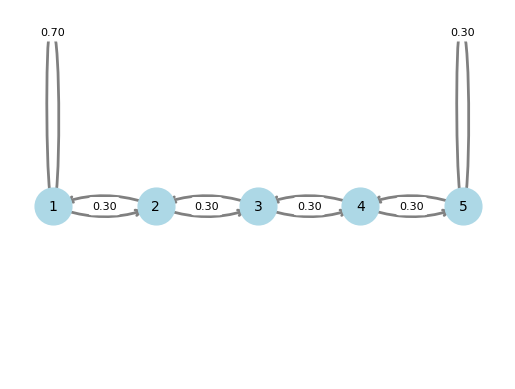

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
n: int = 5
p: float = 0.3
P: np.array = build_p_matrices(chain=1, p_values=[p], n_values=[n])[0]
states: list[int] = [i for i in range (1, n + 1)]

edges: list[tuple] = []
k: int = 0
for i in range(n):
    for j in range(n):
        if P[i][j] != 0:
            edges.append((i + 1, j + 1, k))
            k += 1

print(P)
print(edges)

# Arrange nodes linearly on the x-axis
pos = {state: (state, 0) for state in states}
G.add_nodes_from(states)
G.add_edges_from(edges)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10, edge_color='gray', width=2, connectionstyle="arc3,rad=0.2")
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

edge_labels = {}
for i in range(n):
    for j in range(n):
        if P[i][j] != 0:
            edge_labels[(i + 1, j + 1)] = f'{P[i][j]:.2f}'

print(edge_labels)

nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

plt.axis('off')
plt.show()

## Métodos para encontrar la distribución estacionaria

Ya que las cadenas presentadas anteriormente son irreducibles y aperiódicas, su distribución estacionaria existe y es única. Ahora, se calculará usando dos métodos diferentes, comparando la eficiencia temporal de estos:

### Hallando los autovectores de $P^\intercal$

Se sabe que una distribución $\pi$ se le llama estacionaria si
$$\pi P = \pi$$
o equivalentemente
$$P^{\intercal} \pi^{\intercal} = \pi^{\intercal}$$
por lo tanto, hallar $\pi$ se reduce a hallar un autovector de la matriz $P^{\intercal}$.

Dicho autovector se hallará utilizando las librerías `numpy` y `scipy`, las más populares en cálculo científico, y `simpy`, una librería de cálculo simbólico. Normalmente, bastaría con la primera, mas sin embargo, como explican en [esta pregunta en StackOverflow](https://stackoverflow.com/questions/6684238/whats-the-fastest-way-to-find-eigenvalues-vectors-in-python), `scipy` identifica diversos tipos de matrices y ajusta los cálculos de los autovectores de acuerdo al mejor algoritmo que aplique para cada tipo. Por otro lado, `simpy` seguramente será la más lenta de las tres, pero proverá una buena indicación de qué tanto tardaría el proceso si se busca exactitud en la solución (o precisión casi infinita).

Ahora, independientemente de qué librería o lenguaje se utilice, es estándar retornar los autovectores normalizados (bajo la norma euclídea estándar). Por lo tanto, se deberá hacer un cálculo extra para asegurar que al menos uno de los autovectores $v$ cumpla que $\sum_{i = 1}^{n}v_i = 1$ y que $0 \leq v_i \leq 1$ para todo $i \in \{1, ..., n\}$. Este consiste en computar un escalar $x \in \mathbb{R}$ tal que

$$\frac{\sum_{i = 1}^n v_i}{x} = 1 \iff x = \sum_{i = 1}^n v_i$$

y dividir a cada componente del vector $v$ para obtener un candidato a distribución estacionaria $v' = (\frac{v_1}{x}, \frac{v_2}{x}, ..., \frac{v_n}{x})$.

#### Cadena 1

In [8]:
matrices = build_p_matrices(chain=1, p_values=[n/10 for n in range (1, 10)], n_values=[n for n in range(2, 10)])

In [9]:
#!Consider creating an object that stores all the matrices with n states to have a better reference when printing

In [10]:
import scipy

print("   Using scipy...")

candidates: list[list[np.array]] = []
for i in range(len(matrices)):
    print(f"Candidates for {i}th matrix")
    eigen_values, eigen_vectors = scipy.linalg.eig(matrices[i])
    current_candidates: list[np.array] = []
    for v in eigen_vectors:
        current_candidates.append(v/v.sum())
    print(current_candidates)
    candidates.append(current_candidates)


   Using scipy...
Candidates for 0th matrix
[array([ 3.46570295, -2.46570295]), array([0.13507811, 0.86492189])]
Candidates for 1th matrix
[array([ 3.68825384, -2.68825384]), array([0.25539679, 0.74460321])]
Candidates for 2th matrix
[array([ 4.33480768, -3.33480768]), array([0.35777472, 0.64222528])]
Candidates for 3th matrix
[array([ 6.65941171, -5.65941171]), array([0.43960781, 0.56039219])]
Candidates for 4th matrix
[array([ 3.18452584e+15, -3.18452584e+15]), array([0.5, 0.5])]
Candidates for 5th matrix
[array([0.56039219, 0.43960781]), array([-5.65941171,  6.65941171])]
Candidates for 6th matrix
[array([0.64222528, 0.35777472]), array([-3.33480768,  4.33480768])]
Candidates for 7th matrix
[array([0.74460321, 0.25539679]), array([-2.68825384,  3.68825384])]
Candidates for 8th matrix
[array([0.86492189, 0.13507811]), array([-2.46570295,  3.46570295])]
Candidates for 9th matrix
[array([ 0.82320452, -0.48734828,  0.66414375]), array([ 0.30642024,  2.17685944, -1.48327968]), array([-0.

In [11]:
print_distributions(get_distributions(candidates))
#!Precission issue


Stationary distribution of the 1th matrix
[array([0.13507811, 0.86492189])]
Stationary distribution of the 2th matrix
[array([0.25539679, 0.74460321])]
Stationary distribution of the 3th matrix
[array([0.35777472, 0.64222528])]
Stationary distribution of the 4th matrix
[]
Stationary distribution of the 5th matrix
[array([0.5, 0.5])]
Stationary distribution of the 6th matrix
[]
Stationary distribution of the 7th matrix
[]
Stationary distribution of the 8th matrix
[array([0.74460321, 0.25539679])]
Stationary distribution of the 9th matrix
[array([0.86492189, 0.13507811])]
Stationary distribution of the 10th matrix
[]
Stationary distribution of the 11th matrix
[array([0.2304589 , 0.41750931, 0.35203179])]
Stationary distribution of the 12th matrix
[array([0.22268549, 0.41196156, 0.36535295])]
Stationary distribution of the 13th matrix
[array([0.22481159, 0.39097863, 0.38420978])]
Stationary distribution of the 14th matrix
[]
Stationary distribution of the 15th matrix
[array([0.2735456 , 0

In [12]:
print("   Using numpy...")

candidates: list[list[np.array]] = []
for i in range(len(matrices)):
    print(f"Candidates for {i}th matrix")
    eigen_values, eigen_vectors = np.linalg.eig(matrices[i])
    current_candidates: list[np.array] = []
    for v in eigen_vectors:
        current_candidates.append(v/v.sum())
        #!Check if appending correctly
    print(current_candidates)
    candidates.append(current_candidates)


   Using numpy...
Candidates for 0th matrix
[array([ 3.46570295, -2.46570295]), array([0.13507811, 0.86492189])]
Candidates for 1th matrix
[array([ 3.68825384, -2.68825384]), array([0.25539679, 0.74460321])]
Candidates for 2th matrix
[array([ 4.33480768, -3.33480768]), array([0.35777472, 0.64222528])]
Candidates for 3th matrix
[array([ 6.65941171, -5.65941171]), array([0.43960781, 0.56039219])]
Candidates for 4th matrix
[array([ 3.18452584e+15, -3.18452584e+15]), array([0.5, 0.5])]
Candidates for 5th matrix
[array([0.56039219, 0.43960781]), array([-5.65941171,  6.65941171])]
Candidates for 6th matrix
[array([0.64222528, 0.35777472]), array([-3.33480768,  4.33480768])]
Candidates for 7th matrix
[array([0.74460321, 0.25539679]), array([-2.68825384,  3.68825384])]
Candidates for 8th matrix
[array([0.86492189, 0.13507811]), array([-2.46570295,  3.46570295])]
Candidates for 9th matrix
[array([ 0.82320452, -0.48734828,  0.66414375]), array([ 0.30642024,  2.17685944, -1.48327968]), array([-0.

In [13]:
print_distributions(get_distributions(candidates))

Stationary distribution of the 1th matrix
[array([0.13507811, 0.86492189])]
Stationary distribution of the 2th matrix
[array([0.25539679, 0.74460321])]
Stationary distribution of the 3th matrix
[array([0.35777472, 0.64222528])]
Stationary distribution of the 4th matrix
[]
Stationary distribution of the 5th matrix
[array([0.5, 0.5])]
Stationary distribution of the 6th matrix
[]
Stationary distribution of the 7th matrix
[]
Stationary distribution of the 8th matrix
[array([0.74460321, 0.25539679])]
Stationary distribution of the 9th matrix
[array([0.86492189, 0.13507811])]
Stationary distribution of the 10th matrix
[]
Stationary distribution of the 11th matrix
[array([0.2304589 , 0.41750931, 0.35203179])]
Stationary distribution of the 12th matrix
[array([0.22268549, 0.41196156, 0.36535295])]
Stationary distribution of the 13th matrix
[array([0.22481159, 0.39097863, 0.38420978])]
Stationary distribution of the 14th matrix
[]
Stationary distribution of the 15th matrix
[array([0.2735456 , 0

### Usando la fórmula de recurrencia

Ya que las cadenas trabajadas son homogéneas, aperiódicas e irreducibles, la distribución estacionaria es única por el teorema 5.3 visto en clase. Además, por ejercicio ... (realizar ejercicio), se sabe que esta distribución tendrá la forma
$$\pi = \left(\frac{1}{\mathbb{E}_1[T_1^+]}, \frac{1}{\mathbb{E}_2[T_2^+]}, ..., \frac{1}{\mathbb{E}_n[T_n^+]}\right) = \left(\frac{1}{r_1}, \frac{1}{r_2}, ..., \frac{1}{r_n}\right)$$
Además, para todo $i \in \{1, ..., n\}$, $r_i := \mathbb{E}_i[T_i^+] = 1 + \sum_{j \in S}P_{ij} t_{j, \{i\}}$, y como $t_{i, \{i\}} := \mathbb{E}_i[T_i] = 0$ (pues si $X_0 = i, ya se está en el estado al que se quería retornar), se puede descartar el caso en que $j = i$. Luego, 
$$r_i = \mathbb{E}_i[T_i^+] = 1 + \sum_{j \in S, j \neq i}P_{ij} t_{j, \{i\}} = (\pi_i)^{-1}$$
donde $\pi$ es la distribución estacionaria de cada cadena, $P$ es la matriz de transición de la cadena, y $t_{j, \{i\}} := \mathbb{E}_i[T_{\{i\}}] = 1 + \sum_{j \in S^t} P_{ij} t_{j, \{i\}}$ el tiempo medio de llegada al estado $i$ desde el estado $j$.

La forma de calcular los tiempos medios de llegada a un estado desde otro es recurrentemente, es decir, se va formando un sistema de ecuaciones con los $i, j \in S$ necesarios para poder calcular los $t_{j, \{i\}}$ requeridos. Este cálculo se realizará a continuación representando dicho sistema como una matriz que va creciendo a medida en que se requiren más $t_{j, \{i\}}$.

Idea: hacer un llamado recurrente cada que se necesite un $t_{ij}$ e irlos almacenando en una lista. Hacer una máscara con los elementos de la suma que sean $0$ (e.g., $t_{ii}$); si el único no sero es el $t_{ij}$ requerido, se puede calcular con una suma directa. De otro modo, se buscarán los $t_{ik}$ necesarios en la lista, y si no están, se hace un llamado recurrente.

In [14]:
matrices = build_p_matrices(chain=1, p_values=[n/10 for n in range (1, 10)], n_values=[n for n in range(2, 10)])

In [15]:
def calculate_st_distr_rf(matrix: np.array) -> np.array:
    """
    Function to calculate the stationary distribution of a Markov chain
    with transition matrix `matrix` using the recurrence formulas
    """
    r: list[float] = []
    for i in range(matrix.shape[0]):
        r.append()

**Considerar el ejemplo en el que la distr es (1, 0, 0, 0, 0) como argumento a favor de los autovectores**